# MD+ Datathon
### Neuroncdocs Team

# Predictive Modeling
### Inputs
* `user_id`: User ID. There are duplicates, but the unique values are 42283 users. No passes 

* `age`: User's age. Based on the statistics, there are some anomalies such as the minimum age is -196691 and the maximum age is 2018. More processing or filtering may be required. There are also quite a lot of missing values 309226. It might be worth replacing them with the mean or median value
  
* `sex`: User gender. There are 132135 missing values. Requires conversion from a categorical variable to a numeric variable. And it is important to check why there are 4 unique values. Gaps should be replaced with the value unknown
  
* `country`: User's country. There are 297985 missing values. Requires conversion from a categorical variable to a numeric variable. Gaps should be replaced with the value unknown
  
* `checkin_date`: Tracking date. It is important to convert to datetime format for ease of use. No passes
  
* `trackable_id`: ID of the event being tracked. Unique values, 264603 events. It's probably possible to delete the column, but not sure yet. No passes trackable_type: The type of event to track. 7 unique types. Explore all types. No passes ('trackable_type' --> 'trackable_name')
  - `Condition` --> condition_keyword_groups
  - `Symptom` --> symptom_keyword_groups
  - `Food` --> food_keyword_groups()
  - `Tag` --> tag_keyword_groups()
  - `Weather` --> `icon`, `temperature_min`, `temperature_max`, `precip_intensity`, `pressure`, `humidity`
  - `HBI`
    
* `trackable_name`: Name of the event being tracked, description of symptoms. 117214 unique values. There are 4 gaps
  
* `trackable_value`: The value of the trackable event. 15960 unique values - severity for some conditions (0-4)


| **Domain**    | **Description** |
|----------------|-----------------|
| **Tags** | Self-reported contextual or psychosocial states (e.g., stress, fatigue, sleep quality). |
| **Foods** | Dietary items categorized via hierarchical clusters (e.g., vegetables, processed foods, caffeine). |
| **Treatments** | Medications, supplements, and therapeutic interventions (e.g., NSAIDs, SSRIs, biologics). |
| **Weather** | Daily environmental data including maximum/minimum temperature, humidity, barometric pressure, and precipitation. |
| **Symptoms** | Intensity scores and qualitative reports of user-experienced symptoms across multiple domains. |
| **Conditions** | Known or self-reported disease diagnoses (e.g., Major Depressive Disorder, Rheumatoid Arthritis, POTS). |



### Outputs

* **Conditions:**  Predictive models estimating the probability of new or worsening disease diagnosis **within 30 days** of a given user check-in.
* **Symptoms:**  Short-term forecasting models estimating daily symptom fluctuations or flare probability.


| Condition | Prediction Horizon | Description |
|------------|--------------------|--------------|
| **Postural Orthostatic Tachycardia Syndrome (POTS)** | 30 days | Predicts initial or recurrent episodes of orthostatic intolerance (tachycardia, dizziness, lightheadedness) within the next 30 days. |
| **Epilepsy** | 30 days | Predicts the first onset or reporting of epilepsy symptoms or diagnosis within the next 30 days. |
| **Depression** | 30 days | Forecasts whether a user will report depressive symptoms or receive a depression-related condition within 30 days. |
| **Anxiety** | 30 days | Estimates the likelihood of anxiety-related symptom onset or diagnosis within the next 30 days. |

| Symptom | Prediction Horizon | Description |
|----------|--------------------|--------------|
| **Inflammatory / Rheumatoid Arthritis flares** | Next day | Predicts short-term symptom worsening (pain, swelling, stiffness) indicative of an inflammatory arthritis flare the following day. |

---

### Model

**Light Gradient Boosting Classifier (LightGBM)**  
A high-performance, tree-based gradient boosting algorithm optimized for structured and tabular health data.

**Key Features**
- Handles **missing values**, **categorical encoding**, and **imbalanced data** efficiently.  
- Integrates **rolling temporal features** (7-day and 30-day symptom, treatment, and environmental aggregates).  
- Provides **feature importance rankings** for interpretability and clinical insight.  
- Tuned for each prediction target (condition or symptom) using class weighting, learning rate adjustment, and ensemble depth optimization.

**Model configuration**
```python
lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

In [83]:
# Setup
import pandas as pd
from collections import defaultdict
import numpy as np
import re
from datetime import timedelta

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, precision_recall_curve
)


### Model Evaluation function

In [85]:
def evaluate_and_store_results(model_name, y_true, y_prob, feature_cols, model, results_path="model_results.csv", threshold=0.5):
    """
    Evaluate model performance, extract metrics, feature importance,
    and append results to a centralized CSV for later comparison.
    """

    # --- Probabilistic metrics ---
    auc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)

    # --- Binary metrics ---
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # --- Store feature importance (if available) ---
    if hasattr(model, "feature_importances_"):
        feature_importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
        top_features = ", ".join(feature_importances.head(10).index)
    else:
        top_features = "N/A"

    # --- Package results ---
    result = {
        "Model": model_name,
        "AUC": round(auc, 3),
        "AUPRC": round(auprc, 3),
        "Sensitivity": round(sensitivity, 3),
        "Specificity": round(specificity, 3),
        "Top_Features": top_features
    }

    # --- Append to master results CSV ---
    try:
        existing = pd.read_csv(results_path)
        updated = pd.concat([existing, pd.DataFrame([result])], ignore_index=True)
    except FileNotFoundError:
        updated = pd.DataFrame([result])

    updated.to_csv(results_path, index=False)
    print(f"✅ Results saved to {results_path}")
    print(f"\n{pd.DataFrame([result])}")

    return result


---
# Inputs
### Loading clusters or labeled data

In [87]:
# Load all CSVs
conditions_df = pd.read_csv("conditions_clusters.csv")
symptoms_df = pd.read_csv("symptoms_clusters.csv")
food_df = pd.read_csv("foods_clusters.csv")
tags_df = pd.read_csv("tags_clusters.csv")
treatments_df = pd.read_csv("treatments_clusters.csv")

In [88]:
def build_keyword_groups(df):
    groups = defaultdict(list)
    for _, row in df.iterrows():
        term = str(row["term_original"]).strip()
        domain = str(row["best_domain"]).strip()
        if term and domain and domain.lower() != "nan":
            groups[domain].append(term)
            # Optionally, include capitalized version for robust matching
            groups[domain].append(term.capitalize())
    return dict(groups)

In [89]:
condition_keyword_groups = build_keyword_groups(conditions_df)
symptom_keyword_groups = build_keyword_groups(symptoms_df)
food_keyword_groups = build_keyword_groups(food_df)
tag_keyword_groups = build_keyword_groups(tags_df)
treatment_keyword_groups = build_keyword_groups(treatments_df)

---
# Gradient Boosting Models

### Predicting Onset of Epilepsy after 30 Days

In [92]:
# ========= 1) LOAD & CLEAN =========
# Assumes your full long-format table is in df with the columns you listed
path = "/Users/cristybanuelos/Downloads/Chronic_Illness_Dataset.csv"
df = pd.read_csv(path)

df = df[df["trackable_type"] == "Condition"].copy()
df["condition_clean"] = (
    df["trackable_name"].str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
)

# Parse date
df["checkin_date"] = pd.to_datetime(df["checkin_date"], errors="coerce")
df = df.dropna(subset=["checkin_date"])  # keep only rows with a date

# Basic user-level fields
# Age cleaning: clip to a sensible window; set out-of-range to NaN, then impute
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.loc[(df["age"] < 0) | (df["age"] > 110), "age"] = np.nan  # clip biologically plausible ages
df["age"] = df.groupby("user_id")["age"].transform(lambda s: s.fillna(s.median()))
df["age"] = df["age"].fillna(df["age"].median())

# Sex cleaning: normalize categories
def norm_sex(x):
    x = str(x).strip().lower()
    if x in {"male", "m"}: return "male"
    if x in {"female", "f"}: return "female"
    if x in {"nan", "none", "", "unknown"}: return "unknown"
    return "other"
df["sex"] = df["sex"].apply(norm_sex)

# Country cleaning
def norm_country(x):
    x = str(x).strip()
    return "unknown" if (x == "" or x.lower() == "nan") else x
df["country"] = df["country"].apply(norm_country)

# ========= 2) TEXT NORMALIZATION (for matching) =========
# Create a clean text column for matching on trackable_name
df["name_clean"] = (
    df["trackable_name"]
    .fillna("")
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# ========= 3) HELPERS TO FLAG KEYWORDS =========
def add_keyword_flags(sub_df, groups_dict, prefix):
    """
    For a subset of df (e.g., only Symptoms, only Food...), add binary columns
    indicating whether trackable_name matches any keyword group for that row.
    We then aggregate to daily features later.
    """
    out = sub_df.copy()
    for group, kws in groups_dict.items():
        # Prebuild a regex OR pattern for speed; escape non-alnum safely
        pattern = r"(" + "|".join([re.escape(k.lower()) for k in kws]) + r")"
        col = f"{prefix}__{group}"
        out[col] = out["name_clean"].str.contains(pattern, regex=True).astype(int)
    return out

# ========= 4) PER-TYPE KEYWORD FLAGS =========
# NOTE: You already have: keyword_groups (conditions incl. "epilepsy_seizure"),
#       symptom_keyword_groups, food_keyword_groups, tag_keyword_groups, treatment_keyword_groups

# Conditions (Condition rows only)
cond_rows = df[df["trackable_type"] == "Condition"]
cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")

# Symptoms
sym_rows = df[df["trackable_type"] == "Symptom"]
sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")

# Food
food_rows = df[df["trackable_type"] == "Food"]
food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")

# Tags (triggers)
tag_rows = df[df["trackable_type"] == "Tag"]
tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")

# Treatments
trt_rows = df[df["trackable_type"] == "Treatment"]
trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")

# Weather (already numeric columns; keep as-is if present)
weather_rows = df[df["trackable_type"] == "Weather"].copy()
# Example expected numeric weather columns (adjust to your schema if needed)
for col in ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]:
    if col in weather_rows.columns:
        weather_rows[col] = pd.to_numeric(weather_rows[col], errors="coerce")

# ========= 5) DAILY AGGREGATION (no leakage) =========
# We build daily features per user, then later roll 7/30d windows that use ONLY past data.

def daily_agg_flags(sub, prefix):
    # get only the flag columns
    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])
    # include severity if available (0-4); we’ll take max per day
    if "trackable_value" in sub.columns:
        sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")
    else:
        sub["severity_val"] = np.nan

    agg = (
        sub.groupby(["user_id", "checkin_date"])
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
           .reset_index()
    )
    # rename severity
    if "severity_val" in agg.columns:
        agg = agg.rename(columns={"severity_val": f"{prefix}__max_severity"})
    return agg

daily_cond = daily_agg_flags(cond_rows,  "cond")
daily_sym  = daily_agg_flags(sym_rows,   "sym")
daily_food = daily_agg_flags(food_rows,  "food")
daily_tag  = daily_agg_flags(tag_rows,   "tag")
daily_trt  = daily_agg_flags(trt_rows,   "trt")

# Daily weather (mean if multiple in same day)
if not weather_rows.empty:
    wcols = ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]
    wcols = [c for c in wcols if c in weather_rows.columns]
    daily_wx = (
        weather_rows.groupby(["user_id", "checkin_date"])[wcols].mean().reset_index()
    )
else:
    daily_wx = pd.DataFrame(columns=["user_id", "checkin_date"])

# ========= Combine into one daily table =========
# Start from all user-day keys present in any table
parts = [daily_cond, daily_sym, daily_food, daily_tag, daily_trt, daily_wx]
daily = None
for p in parts:
    if p is None or p.empty: 
        continue
    daily = p if daily is None else pd.merge(daily, p, on=["user_id", "checkin_date"], how="outer")

if daily is None:
    raise ValueError("No daily features built. Check your inputs.")

daily = daily.sort_values(["user_id", "checkin_date"]).reset_index(drop=True)
daily = daily.fillna(0)  # for flags; numeric weather stays 0 if missing (fine for tree models)

# ========= 6) ROLLING (PAST-ONLY) FEATURES =========
# For each user, compute 7d/30d rolling sums of flags + rolling means of severities & weather.
def add_rollups(g):
    g = g.set_index("checkin_date").sort_index()
    # rolling windows (closed='left' to use ONLY past)
    win_defs = {"7d":"7D", "30d":"30D"}
    for col in g.columns:
        if col.startswith(("cond__", "sym__", "food__", "tag__", "trt__")) and col.endswith("__max_severity") is False:
            for k, win in win_defs.items():
                g[f"{col}__sum_{k}"] = g[col].rolling(win, closed="left").sum()
        # severities & weather: rolling mean
        if col.endswith("__max_severity") or col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
            for k, win in win_defs.items():
                g[f"{col}__mean_{k}"] = g[col].rolling(win, closed="left").mean()
    return g.reset_index()

daily = daily.groupby("user_id", group_keys=False).apply(add_rollups)
# Fill remaining NaNs from leading window edges
daily = daily.fillna(0)

# ========= 7) BUILD THE TARGET: FIRST-EVER EPILEPSY ONSET IN NEXT 30 DAYS =========
# Find first date epilepsy is reported per user (Condition rows matched to epilepsy group)
epi_flag_cols = [c for c in daily.columns if c.startswith("cond__epilepsy_seizure")]
if not epi_flag_cols:
    raise ValueError("No epilepsy condition flag found. Ensure 'epilepsy_seizure' exists in keyword_groups for Conditions.")

# Daily presence of epilepsy (same-day)
daily["has_epilepsy_today"] = daily[epi_flag_cols].max(axis=1)

# First-ever epilepsy date
first_epi = (
    daily[daily["has_epilepsy_today"] > 0]
    .groupby("user_id", as_index=False)["checkin_date"].min()
    .rename(columns={"checkin_date":"first_epilepsy_date"})
)

# Merge back
daily = daily.merge(first_epi, on="user_id", how="left")

# Labeling:
# On a given day t (index row), y=1 if first epilepsy date falls in (t, t+30] AND user has not had epilepsy before t.
daily["label_onset_30d"] = 0
mask_has_future = (~daily["first_epilepsy_date"].isna())
daily.loc[mask_has_future, "label_onset_30d"] = (
    (daily["first_epilepsy_date"] > daily["checkin_date"]) &
    (daily["first_epilepsy_date"] <= daily["checkin_date"] + pd.Timedelta(days=30))
).astype(int)

# Exclude rows ON/AFTER first epilepsy (we’re predicting onset, not after it happens)
daily = daily[(daily["first_epilepsy_date"].isna()) | (daily["checkin_date"] < daily["first_epilepsy_date"])]

# Optional: require a minimum history window (e.g., at least 30 past days) to form features
daily["has_30d_history"] = daily.groupby("user_id")["checkin_date"].transform(
    lambda s: (s - s.min()) >= pd.Timedelta(days=30)
)
daily = daily[daily["has_30d_history"]]

# ========= 8) ADD DEMOGRAPHICS (static) =========
# Build a static per-user table (age/sex/country) at any row; then merge with daily
demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
daily = daily.merge(demo, on="user_id", how="left")

# One-hot encode sex & country (country can be many; consider top-K and bucket rest as 'other')
# Keep top 20 countries to control dimensionality
top_countries = df["country"].value_counts().head(20).index
daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries), "other")

X_cat = pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)
daily = pd.concat([daily.drop(columns=["sex","country","country_top"]), X_cat], axis=1)

# ========= 9) TRAIN / TEST TEMPORAL SPLIT =========
# Choose a cutoff date (e.g., last year as test). Adjust to your range.
cutoff = daily["checkin_date"].quantile(0.8)  # 80% oldest for train, 20% most recent for test
train = daily[daily["checkin_date"] <= cutoff].copy()
test  = daily[daily["checkin_date"] >  cutoff].copy()

# Features: use all engineered columns except identifiers and leakage columns
leaky_cols = [
    "cond__max_severity__mean_30d",
    "cond__max_severity__mean_7d", 
    "cond__max_severity"
]
drop_cols = {
    "user_id", "checkin_date", "first_epilepsy_date",
    "has_epilepsy_today", "has_30d_history", "label_onset_30d"
}.union(leaky_cols)

feature_cols = [c for c in daily.columns if c not in drop_cols]

X_train = train[feature_cols]
y_train = train["label_onset_30d"].astype(int)
X_test  = test[feature_cols]
y_test  = test["label_onset_30d"].astype(int)

# Optional: scale numeric continuous columns (LightGBM doesn’t require it)

# ========= 10) TRAIN LIGHTGBM =========
clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

# ========= 11) EVALUATE =========
p_test = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, p_test)
auprc = average_precision_score(y_test, p_test)

print(f"AUC  : {auc:.3f}")
print(f"AUPRC: {auprc:.3f}")

# Optional: show precision/recall at a few thresholds
prec, rec, thr = precision_recall_curve(y_test, p_test)
for t in [0.05, 0.10, 0.20]:
    # nearest threshold
    idx = (np.abs(thr - t)).argmin() if len(thr) else -1
    if idx >= 0 and idx < len(prec):
        print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f}  Recall={rec[idx]:.3f}")

# Evaluate and store results
model_name = "Epilepsy_30d_LGBM"  # or "Epilepsy_30d", "RA_NextDay", etc.
evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")

# ========= 12) FEATURE IMPORTANCE =========
imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop 25 features:\n", imp.head(25))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62, number of negative: 112097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2594
[LightGBM] [Info] Number of data points in the train set: 112159, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Predicting Onset of Depression after 30 Days

In [94]:
# ========= 1) LOAD & CLEAN =========
# Assumes your full long-format table is in df with the columns you listed
path = "/Users/cristybanuelos/Downloads/Chronic_Illness_Dataset.csv"
df = pd.read_csv(path)

df = df[df["trackable_type"] == "Condition"].copy()
df["condition_clean"] = (
    df["trackable_name"].str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
)

# Parse date
df["checkin_date"] = pd.to_datetime(df["checkin_date"], errors="coerce")
df = df.dropna(subset=["checkin_date"])  # keep only rows with a date

# Basic user-level fields
# Age cleaning: clip to a sensible window; set out-of-range to NaN, then impute
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.loc[(df["age"] < 0) | (df["age"] > 110), "age"] = np.nan  # clip biologically plausible ages
df["age"] = df.groupby("user_id")["age"].transform(lambda s: s.fillna(s.median()))
df["age"] = df["age"].fillna(df["age"].median())

# Sex cleaning: normalize categories
def norm_sex(x):
    x = str(x).strip().lower()
    if x in {"male", "m"}: return "male"
    if x in {"female", "f"}: return "female"
    if x in {"nan", "none", "", "unknown"}: return "unknown"
    return "other"
df["sex"] = df["sex"].apply(norm_sex)

# Country cleaning
def norm_country(x):
    x = str(x).strip()
    return "unknown" if (x == "" or x.lower() == "nan") else x
df["country"] = df["country"].apply(norm_country)

# ========= 2) TEXT NORMALIZATION (for matching) =========
# Create a clean text column for matching on trackable_name
df["name_clean"] = (
    df["trackable_name"]
    .fillna("")
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# ========= 3) HELPERS TO FLAG KEYWORDS =========
def add_keyword_flags(sub_df, groups_dict, prefix):
    """
    For a subset of df (e.g., only Symptoms, only Food...), add binary columns
    indicating whether trackable_name matches any keyword group for that row.
    We then aggregate to daily features later.
    """
    out = sub_df.copy()
    for group, kws in groups_dict.items():
        # Prebuild a regex OR pattern for speed; escape non-alnum safely
        pattern = r"(" + "|".join([re.escape(k.lower()) for k in kws]) + r")"
        col = f"{prefix}__{group}"
        out[col] = out["name_clean"].str.contains(pattern, regex=True).astype(int)
    return out

# ========= 4) PER-TYPE KEYWORD FLAGS =========
# NOTE: You already have: keyword_groups (conditions incl. "epilepsy_seizure"),
#       symptom_keyword_groups, food_keyword_groups, tag_keyword_groups, treatment_keyword_groups

# Conditions (Condition rows only)
cond_rows = df[df["trackable_type"] == "Condition"]
cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")

# Symptoms
sym_rows = df[df["trackable_type"] == "Symptom"]
sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")

# Food
food_rows = df[df["trackable_type"] == "Food"]
food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")

# Tags (triggers)
tag_rows = df[df["trackable_type"] == "Tag"]
tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")

# Treatments
trt_rows = df[df["trackable_type"] == "Treatment"]
trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")

# Weather (already numeric columns; keep as-is if present)
weather_rows = df[df["trackable_type"] == "Weather"].copy()
# Example expected numeric weather columns (adjust to your schema if needed)
for col in ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]:
    if col in weather_rows.columns:
        weather_rows[col] = pd.to_numeric(weather_rows[col], errors="coerce")

# ========= 5) DAILY AGGREGATION (no leakage) =========
# We build daily features per user, then later roll 7/30d windows that use ONLY past data.

def daily_agg_flags(sub, prefix):
    # get only the flag columns
    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])
    # include severity if available (0-4); we’ll take max per day
    if "trackable_value" in sub.columns:
        sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")
    else:
        sub["severity_val"] = np.nan

    agg = (
        sub.groupby(["user_id", "checkin_date"])
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
           .reset_index()
    )
    # rename severity
    if "severity_val" in agg.columns:
        agg = agg.rename(columns={"severity_val": f"{prefix}__max_severity"})
    return agg

daily_cond = daily_agg_flags(cond_rows,  "cond")
daily_sym  = daily_agg_flags(sym_rows,   "sym")
daily_food = daily_agg_flags(food_rows,  "food")
daily_tag  = daily_agg_flags(tag_rows,   "tag")
daily_trt  = daily_agg_flags(trt_rows,   "trt")

# Daily weather (mean if multiple in same day)
if not weather_rows.empty:
    wcols = ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]
    wcols = [c for c in wcols if c in weather_rows.columns]
    daily_wx = (
        weather_rows.groupby(["user_id", "checkin_date"])[wcols].mean().reset_index()
    )
else:
    daily_wx = pd.DataFrame(columns=["user_id", "checkin_date"])

# ========= Combine into one daily table =========
# Start from all user-day keys present in any table
parts = [daily_cond, daily_sym, daily_food, daily_tag, daily_trt, daily_wx]
daily = None
for p in parts:
    if p is None or p.empty: 
        continue
    daily = p if daily is None else pd.merge(daily, p, on=["user_id", "checkin_date"], how="outer")

if daily is None:
    raise ValueError("No daily features built. Check your inputs.")

daily = daily.sort_values(["user_id", "checkin_date"]).reset_index(drop=True)
daily = daily.fillna(0)  # for flags; numeric weather stays 0 if missing (fine for tree models)

# ========= 6) ROLLING (PAST-ONLY) FEATURES =========
# For each user, compute 7d/30d rolling sums of flags + rolling means of severities & weather.
def add_rollups(g):
    g = g.set_index("checkin_date").sort_index()
    # rolling windows (closed='left' to use ONLY past)
    win_defs = {"7d":"7D", "30d":"30D"}
    for col in g.columns:
        if col.startswith(("cond__", "sym__", "food__", "tag__", "trt__")) and col.endswith("__max_severity") is False:
            for k, win in win_defs.items():
                g[f"{col}__sum_{k}"] = g[col].rolling(win, closed="left").sum()
        # severities & weather: rolling mean
        if col.endswith("__max_severity") or col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
            for k, win in win_defs.items():
                g[f"{col}__mean_{k}"] = g[col].rolling(win, closed="left").mean()
    return g.reset_index()

daily = daily.groupby("user_id", group_keys=False).apply(add_rollups)
# Fill remaining NaNs from leading window edges
daily = daily.fillna(0)

# ========= 7) BUILD THE TARGET: FIRST-EVER DEPRESSION ONSET IN NEXT 30 DAYS =========
# Find first date depression is reported per user (Condition rows matched to depression group)
dep_flag_cols = [c for c in daily.columns if c.startswith("cond__depression")]
if not dep_flag_cols:
    raise ValueError("No depression condition flag found. Ensure 'depression' exists in keyword_groups for Conditions.")

# Daily presence of depression (same-day)
daily["has_depression_today"] = daily[dep_flag_cols].max(axis=1)

# First-ever depression date per user
first_dep = (
    daily[daily["has_depression_today"] > 0]
    .groupby("user_id", as_index=False)["checkin_date"].min()
    .rename(columns={"checkin_date": "first_depression_date"})
)

# Merge back
daily = daily.merge(first_dep, on="user_id", how="left")

# Labeling:
# On a given day t (index row), y=1 if first depression date falls in (t, t+30] AND user has not had depression before t.
daily["label_onset_30d"] = 0
mask_has_future = (~daily["first_depression_date"].isna())
daily.loc[mask_has_future, "label_onset_30d"] = (
    (daily["first_depression_date"] > daily["checkin_date"]) &
    (daily["first_depression_date"] <= daily["checkin_date"] + 
       pd.Timedelta(days=30))
    ).astype(int)

# Exclude rows ON/AFTER first depression (predict onset only)
daily = daily[
    (daily["first_depression_date"].isna())
    | (daily["checkin_date"] < daily["first_depression_date"])
]

# Optional: require a minimum history window (e.g., at least 30 past days)
daily["has_30d_history"] = daily.groupby("user_id")["checkin_date"].transform(
    lambda s: (s - s.min()) >= pd.Timedelta(days=30)
)
daily = daily[daily["has_30d_history"]]


# ========= 8) ADD DEMOGRAPHICS (static) =========
# Build a static per-user table (age/sex/country) at any row; then merge with daily
demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
daily = daily.merge(demo, on="user_id", how="left")

# One-hot encode sex & country (country can be many; consider top-K and bucket rest as 'other')
# Keep top 20 countries to control dimensionality
top_countries = df["country"].value_counts().head(20).index
daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries), "other")

X_cat = pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)
daily = pd.concat([daily.drop(columns=["sex","country","country_top"]), X_cat], axis=1)

# ========= 9) TRAIN / TEST TEMPORAL SPLIT =========
# Choose a cutoff date (e.g., last year as test). Adjust to your range.
cutoff = daily["checkin_date"].quantile(0.8)  # 80% oldest for train, 20% most recent for test
train = daily[daily["checkin_date"] <= cutoff].copy()
test  = daily[daily["checkin_date"] >  cutoff].copy()

# Features: use all engineered columns except identifiers and leakage columns
leaky_cols = [
    "cond__max_severity__mean_30d",
    "cond__max_severity__mean_7d", 
    "cond__max_severity"
]
drop_cols = {
    "user_id", "checkin_date", "first_depression_date",
    "has_depression_today", "has_30d_history", "label_onset_30d"
}.union(leaky_cols)

feature_cols = [c for c in daily.columns if c not in drop_cols]

X_train = train[feature_cols]
y_train = train["label_onset_30d"].astype(int)
X_test  = test[feature_cols]
y_test  = test["label_onset_30d"].astype(int)

# Optional: scale numeric continuous columns (LightGBM doesn’t require it)

# ========= 10) TRAIN LIGHTGBM =========
clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

# ========= 11) EVALUATE =========
p_test = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, p_test)
auprc = average_precision_score(y_test, p_test)

print(f"AUC  : {auc:.3f}")
print(f"AUPRC: {auprc:.3f}")

# Optional: show precision/recall at a few thresholds
prec, rec, thr = precision_recall_curve(y_test, p_test)
for t in [0.05, 0.10, 0.20]:
    # nearest threshold
    idx = (np.abs(thr - t)).argmin() if len(thr) else -1
    if idx >= 0 and idx < len(prec):
        print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f}  Recall={rec[idx]:.3f}")

# Evaluate and store results
model_name = "Depression_30d_LGBM"  # or "Epilepsy_30d", "RA_NextDay", etc.
evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")

# ========= 12) FEATURE IMPORTANCE =========
imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop 25 features:\n", imp.head(25))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 529, number of negative: 81689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 82218, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
AUC  : 0.432
AUPRC: 0.004
Threshold~0.05: Precision=0.000  Recall=0.000
Threshold~0.10: Precision=0.000  Recall=0.000
Threshold~0.20: Precision=0.000  Recall=0.000
✅ Results saved to model_results.csv

                 Model    AUC  AUPRC  Sensitivity  Specificity  \
0  Depression_30d_LGBM  0.432  0.004          0.0          1.0   

                              

### Predicting Onset of Anxiety after 30 Days

In [96]:
# ========= 1) LOAD & CLEAN =========
# Assumes your full long-format table is in df with the columns you listed
path = "/Users/cristybanuelos/Downloads/Chronic_Illness_Dataset.csv"
df = pd.read_csv(path)

df = df[df["trackable_type"] == "Condition"].copy()
df["condition_clean"] = (
    df["trackable_name"].str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
)

# Parse date
df["checkin_date"] = pd.to_datetime(df["checkin_date"], errors="coerce")
df = df.dropna(subset=["checkin_date"])  # keep only rows with a date

# Basic user-level fields
# Age cleaning: clip to a sensible window; set out-of-range to NaN, then impute
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.loc[(df["age"] < 0) | (df["age"] > 110), "age"] = np.nan  # clip biologically plausible ages
df["age"] = df.groupby("user_id")["age"].transform(lambda s: s.fillna(s.median()))
df["age"] = df["age"].fillna(df["age"].median())

# Sex cleaning: normalize categories
def norm_sex(x):
    x = str(x).strip().lower()
    if x in {"male", "m"}: return "male"
    if x in {"female", "f"}: return "female"
    if x in {"nan", "none", "", "unknown"}: return "unknown"
    return "other"
df["sex"] = df["sex"].apply(norm_sex)

# Country cleaning
def norm_country(x):
    x = str(x).strip()
    return "unknown" if (x == "" or x.lower() == "nan") else x
df["country"] = df["country"].apply(norm_country)

# ========= 2) TEXT NORMALIZATION (for matching) =========
# Create a clean text column for matching on trackable_name
df["name_clean"] = (
    df["trackable_name"]
    .fillna("")
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# ========= 3) HELPERS TO FLAG KEYWORDS =========
def add_keyword_flags(sub_df, groups_dict, prefix):
    """
    For a subset of df (e.g., only Symptoms, only Food...), add binary columns
    indicating whether trackable_name matches any keyword group for that row.
    We then aggregate to daily features later.
    """
    out = sub_df.copy()
    for group, kws in groups_dict.items():
        # Prebuild a regex OR pattern for speed; escape non-alnum safely
        pattern = r"(" + "|".join([re.escape(k.lower()) for k in kws]) + r")"
        col = f"{prefix}__{group}"
        out[col] = out["name_clean"].str.contains(pattern, regex=True).astype(int)
    return out

# ========= 4) PER-TYPE KEYWORD FLAGS =========
# NOTE: You already have: keyword_groups (conditions incl. "epilepsy_seizure"),
#       symptom_keyword_groups, food_keyword_groups, tag_keyword_groups, treatment_keyword_groups

# Conditions (Condition rows only)
cond_rows = df[df["trackable_type"] == "Condition"]
cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")

# Symptoms
sym_rows = df[df["trackable_type"] == "Symptom"]
sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")

# Food
food_rows = df[df["trackable_type"] == "Food"]
food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")

# Tags (triggers)
tag_rows = df[df["trackable_type"] == "Tag"]
tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")

# Treatments
trt_rows = df[df["trackable_type"] == "Treatment"]
trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")

# Weather (already numeric columns; keep as-is if present)
weather_rows = df[df["trackable_type"] == "Weather"].copy()
# Example expected numeric weather columns (adjust to your schema if needed)
for col in ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]:
    if col in weather_rows.columns:
        weather_rows[col] = pd.to_numeric(weather_rows[col], errors="coerce")

# ========= 5) DAILY AGGREGATION (no leakage) =========
# We build daily features per user, then later roll 7/30d windows that use ONLY past data.

def daily_agg_flags(sub, prefix):
    # get only the flag columns
    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])
    # include severity if available (0-4); we’ll take max per day
    if "trackable_value" in sub.columns:
        sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")
    else:
        sub["severity_val"] = np.nan

    agg = (
        sub.groupby(["user_id", "checkin_date"])
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
           .reset_index()
    )
    # rename severity
    if "severity_val" in agg.columns:
        agg = agg.rename(columns={"severity_val": f"{prefix}__max_severity"})
    return agg

daily_cond = daily_agg_flags(cond_rows,  "cond")
daily_sym  = daily_agg_flags(sym_rows,   "sym")
daily_food = daily_agg_flags(food_rows,  "food")
daily_tag  = daily_agg_flags(tag_rows,   "tag")
daily_trt  = daily_agg_flags(trt_rows,   "trt")

# Daily weather (mean if multiple in same day)
if not weather_rows.empty:
    wcols = ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]
    wcols = [c for c in wcols if c in weather_rows.columns]
    daily_wx = (
        weather_rows.groupby(["user_id", "checkin_date"])[wcols].mean().reset_index()
    )
else:
    daily_wx = pd.DataFrame(columns=["user_id", "checkin_date"])

# ========= Combine into one daily table =========
# Start from all user-day keys present in any table
parts = [daily_cond, daily_sym, daily_food, daily_tag, daily_trt, daily_wx]
daily = None
for p in parts:
    if p is None or p.empty: 
        continue
    daily = p if daily is None else pd.merge(daily, p, on=["user_id", "checkin_date"], how="outer")

if daily is None:
    raise ValueError("No daily features built. Check your inputs.")

daily = daily.sort_values(["user_id", "checkin_date"]).reset_index(drop=True)
daily = daily.fillna(0)  # for flags; numeric weather stays 0 if missing (fine for tree models)

# ========= 6) ROLLING (PAST-ONLY) FEATURES =========
# For each user, compute 7d/30d rolling sums of flags + rolling means of severities & weather.
def add_rollups(g):
    g = g.set_index("checkin_date").sort_index()
    # rolling windows (closed='left' to use ONLY past)
    win_defs = {"7d":"7D", "30d":"30D"}
    for col in g.columns:
        if col.startswith(("cond__", "sym__", "food__", "tag__", "trt__")) and col.endswith("__max_severity") is False:
            for k, win in win_defs.items():
                g[f"{col}__sum_{k}"] = g[col].rolling(win, closed="left").sum()
        # severities & weather: rolling mean
        if col.endswith("__max_severity") or col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
            for k, win in win_defs.items():
                g[f"{col}__mean_{k}"] = g[col].rolling(win, closed="left").mean()
    return g.reset_index()

daily = daily.groupby("user_id", group_keys=False).apply(add_rollups)
# Fill remaining NaNs from leading window edges
daily = daily.fillna(0)

# ========= 7) BUILD THE TARGET: FIRST-EVER ANXIETY ONSET IN NEXT 30 DAYS =========
# Find first date anxiety is reported per user (Condition rows matched to anxiety group)
anx_flag_cols = [c for c in daily.columns if c.startswith("cond__anxiety")]
if not anx_flag_cols:
    raise ValueError("No anxiety condition flag found. Ensure 'anxiety' exists in keyword_groups for Conditions.")

# Daily presence of anxiety (same-day)
daily["has_anxiety_today"] = daily[anx_flag_cols].max(axis=1)

# First-ever anxiety date per user
first_anx = (
    daily[daily["has_anxiety_today"] > 0]
    .groupby("user_id", as_index=False)["checkin_date"].min()
    .rename(columns={"checkin_date": "first_anxiety_date"})
)

# Merge back
daily = daily.merge(first_anx, on="user_id", how="left")

# Labeling:
# On a given day t (index row), y=1 if first anxiety date falls in (t, t+30] AND user has not had anxiety before t.
daily["label_onset_30d"] = 0
mask_has_future = (~daily["first_anxiety_date"].isna())
daily.loc[mask_has_future, "label_onset_30d"] = (
    (daily["first_anxiety_date"] > daily["checkin_date"]) &
    (daily["first_anxiety_date"] <= daily["checkin_date"] + 
       pd.Timedelta(days=30))
    ).astype(int)

# Exclude rows ON/AFTER first anxiety (predict onset only)
daily = daily[
    (daily["first_anxiety_date"].isna())
    | (daily["checkin_date"] < daily["first_anxiety_date"])
]

# Optional: require a minimum history window (e.g., at least 30 past days)
daily["has_30d_history"] = daily.groupby("user_id")["checkin_date"].transform(
    lambda s: (s - s.min()) >= pd.Timedelta(days=30)
)
daily = daily[daily["has_30d_history"]]


# ========= 8) ADD DEMOGRAPHICS (static) =========
# Build a static per-user table (age/sex/country) at any row; then merge with daily
demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
daily = daily.merge(demo, on="user_id", how="left")

# One-hot encode sex & country (country can be many; consider top-K and bucket rest as 'other')
# Keep top 20 countries to control dimensionality
top_countries = df["country"].value_counts().head(20).index
daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries), "other")

X_cat = pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)
daily = pd.concat([daily.drop(columns=["sex","country","country_top"]), X_cat], axis=1)

# ========= 9) TRAIN / TEST TEMPORAL SPLIT =========
# Choose a cutoff date (e.g., last year as test). Adjust to your range.
cutoff = daily["checkin_date"].quantile(0.8)  # 80% oldest for train, 20% most recent for test
train = daily[daily["checkin_date"] <= cutoff].copy()
test  = daily[daily["checkin_date"] >  cutoff].copy()

# Features: use all engineered columns except identifiers and leakage columns
leaky_cols = [
    "cond__max_severity__mean_30d",
    "cond__max_severity__mean_7d", 
    "cond__max_severity"
]
drop_cols = {
    "user_id", "checkin_date", "first_anxiety_date",
    "has_anxiety_today", "has_30d_history", "label_onset_30d"
}.union(leaky_cols)
feature_cols = [c for c in daily.columns if c not in drop_cols]

X_train = train[feature_cols]
y_train = train["label_onset_30d"].astype(int)
X_test  = test[feature_cols]
y_test  = test["label_onset_30d"].astype(int)

# Optional: scale numeric continuous columns (LightGBM doesn’t require it)

# ========= 10) TRAIN LIGHTGBM =========
clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

# ========= 11) EVALUATE =========
p_test = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, p_test)
auprc = average_precision_score(y_test, p_test)

print(f"AUC  : {auc:.3f}")
print(f"AUPRC: {auprc:.3f}")

# Optional: show precision/recall at a few thresholds
prec, rec, thr = precision_recall_curve(y_test, p_test)
for t in [0.05, 0.10, 0.20]:
    # nearest threshold
    idx = (np.abs(thr - t)).argmin() if len(thr) else -1
    if idx >= 0 and idx < len(prec):
        print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f}  Recall={rec[idx]:.3f}")

# Evaluate and store results
model_name = "Anxiety_30d_LGBM"  # or "Epilepsy_30d", "RA_NextDay", etc.
evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")


# ========= 12) FEATURE IMPORTANCE =========
imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop 25 features:\n", imp.head(25))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 540, number of negative: 80109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 80649, number of used features: 208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
AUC  : 0.453
AUPRC: 0.004
Threshold~0.05: Precision=0.048  Recall=0.024
Threshold~0.10: Precision=0.000  Recall=0.000
Threshold~0.20: Precision=0.000  Recall=0.000
✅ Results saved to model_results.csv

              Model    AUC  AUPRC  Sensitivity  Specificity  \
0  Anxiety_30d_LGBM  0.453  0.004          0.0          1.0   

                                    

### Predicting Onset of POTS after 30 Days

In [98]:
# ========= 1) LOAD & CLEAN =========
# Assumes your full long-format table is in df with the columns you listed
path = "/Users/cristybanuelos/Downloads/Chronic_Illness_Dataset.csv"
df = pd.read_csv(path)

df = df[df["trackable_type"] == "Condition"].copy()
df["condition_clean"] = (
    df["trackable_name"].str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
)

# Parse date
df["checkin_date"] = pd.to_datetime(df["checkin_date"], errors="coerce")
df = df.dropna(subset=["checkin_date"])  # keep only rows with a date

# Basic user-level fields
# Age cleaning: clip to a sensible window; set out-of-range to NaN, then impute
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.loc[(df["age"] < 0) | (df["age"] > 110), "age"] = np.nan  # clip biologically plausible ages
df["age"] = df.groupby("user_id")["age"].transform(lambda s: s.fillna(s.median()))
df["age"] = df["age"].fillna(df["age"].median())

# Sex cleaning: normalize categories
def norm_sex(x):
    x = str(x).strip().lower()
    if x in {"male", "m"}: return "male"
    if x in {"female", "f"}: return "female"
    if x in {"nan", "none", "", "unknown"}: return "unknown"
    return "other"
df["sex"] = df["sex"].apply(norm_sex)

# Country cleaning
def norm_country(x):
    x = str(x).strip()
    return "unknown" if (x == "" or x.lower() == "nan") else x
df["country"] = df["country"].apply(norm_country)

# ========= 2) TEXT NORMALIZATION (for matching) =========
# Create a clean text column for matching on trackable_name
df["name_clean"] = (
    df["trackable_name"]
    .fillna("")
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# ========= 3) HELPERS TO FLAG KEYWORDS =========
def add_keyword_flags(sub_df, groups_dict, prefix):
    """
    For a subset of df (e.g., only Symptoms, only Food...), add binary columns
    indicating whether trackable_name matches any keyword group for that row.
    We then aggregate to daily features later.
    """
    out = sub_df.copy()
    for group, kws in groups_dict.items():
        # Prebuild a regex OR pattern for speed; escape non-alnum safely
        pattern = r"(" + "|".join([re.escape(k.lower()) for k in kws]) + r")"
        col = f"{prefix}__{group}"
        out[col] = out["name_clean"].str.contains(pattern, regex=True).astype(int)
    return out

# ========= 4) PER-TYPE KEYWORD FLAGS =========
# NOTE: You already have: keyword_groups (conditions incl. "epilepsy_seizure"),
#       symptom_keyword_groups, food_keyword_groups, tag_keyword_groups, treatment_keyword_groups

# Conditions (Condition rows only)
cond_rows = df[df["trackable_type"] == "Condition"]
cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")

# Symptoms
sym_rows = df[df["trackable_type"] == "Symptom"]
sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")

# Food
food_rows = df[df["trackable_type"] == "Food"]
food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")

# Tags (triggers)
tag_rows = df[df["trackable_type"] == "Tag"]
tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")

# Treatments
trt_rows = df[df["trackable_type"] == "Treatment"]
trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")

# Weather (already numeric columns; keep as-is if present)
weather_rows = df[df["trackable_type"] == "Weather"].copy()
# Example expected numeric weather columns (adjust to your schema if needed)
for col in ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]:
    if col in weather_rows.columns:
        weather_rows[col] = pd.to_numeric(weather_rows[col], errors="coerce")

# ========= 5) DAILY AGGREGATION (no leakage) =========
# We build daily features per user, then later roll 7/30d windows that use ONLY past data.

def daily_agg_flags(sub, prefix):
    # get only the flag columns
    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])
    # include severity if available (0-4); we’ll take max per day
    if "trackable_value" in sub.columns:
        sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")
    else:
        sub["severity_val"] = np.nan

    agg = (
        sub.groupby(["user_id", "checkin_date"])
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
           .reset_index()
    )
    # rename severity
    if "severity_val" in agg.columns:
        agg = agg.rename(columns={"severity_val": f"{prefix}__max_severity"})
    return agg

daily_cond = daily_agg_flags(cond_rows,  "cond")
daily_sym  = daily_agg_flags(sym_rows,   "sym")
daily_food = daily_agg_flags(food_rows,  "food")
daily_tag  = daily_agg_flags(tag_rows,   "tag")
daily_trt  = daily_agg_flags(trt_rows,   "trt")

# Daily weather (mean if multiple in same day)
if not weather_rows.empty:
    wcols = ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]
    wcols = [c for c in wcols if c in weather_rows.columns]
    daily_wx = (
        weather_rows.groupby(["user_id", "checkin_date"])[wcols].mean().reset_index()
    )
else:
    daily_wx = pd.DataFrame(columns=["user_id", "checkin_date"])

# ========= Combine into one daily table =========
# Start from all user-day keys present in any table
parts = [daily_cond, daily_sym, daily_food, daily_tag, daily_trt, daily_wx]
daily = None
for p in parts:
    if p is None or p.empty: 
        continue
    daily = p if daily is None else pd.merge(daily, p, on=["user_id", "checkin_date"], how="outer")

if daily is None:
    raise ValueError("No daily features built. Check your inputs.")

daily = daily.sort_values(["user_id", "checkin_date"]).reset_index(drop=True)
daily = daily.fillna(0)  # for flags; numeric weather stays 0 if missing (fine for tree models)

# ========= 6) ROLLING (PAST-ONLY) FEATURES =========
# For each user, compute 7d/30d rolling sums of flags + rolling means of severities & weather.
def add_rollups(g):
    g = g.set_index("checkin_date").sort_index()
    # rolling windows (closed='left' to use ONLY past)
    win_defs = {"7d":"7D", "30d":"30D"}
    for col in g.columns:
        if col.startswith(("cond__", "sym__", "food__", "tag__", "trt__")) and col.endswith("__max_severity") is False:
            for k, win in win_defs.items():
                g[f"{col}__sum_{k}"] = g[col].rolling(win, closed="left").sum()
        # severities & weather: rolling mean
        if col.endswith("__max_severity") or col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
            for k, win in win_defs.items():
                g[f"{col}__mean_{k}"] = g[col].rolling(win, closed="left").mean()
    return g.reset_index()

daily = daily.groupby("user_id", group_keys=False).apply(add_rollups)
# Fill remaining NaNs from leading window edges
daily = daily.fillna(0)

# ========= 7) BUILD THE TARGET: FIRST-EVER POTS ONSET IN NEXT 30 DAYS =========
# We detect any condition flag columns corresponding to POTS, regardless of how the
# domain was named in your CSVs (e.g., "pots", "POTS", "postural_orthostatic_tachycardia", etc.)
import re

# Find all condition flag columns (start with "cond__")
cond_flag_cols = [c for c in daily.columns if c.startswith("cond__")]

# Heuristic to find POTS columns by name
pots_pattern = re.compile(r"(?:^|[_\- ])(pots|postural[_\-\s]*orthostatic[_\-\s]*tachycardia)(?:$|[_\- ])", re.I)
pots_flag_cols = [c for c in cond_flag_cols if pots_pattern.search(c.replace("cond__", ""))]

if not pots_flag_cols:
    raise ValueError(
        "No POTS condition flag columns found.\n"
        "Tips:\n"
        "  • Ensure your conditions_clusters.csv best_domain for POTS is consistent (e.g., 'pots' or 'postural_orthostatic_tachycardia').\n"
        "  • Verify those terms appear in 'condition_keyword_groups' and that Step 4 created columns starting with 'cond__'.\n"
        f"  • Available condition flags example: {cond_flag_cols[:30]}"
    )

# Daily presence of POTS (same-day)
daily["has_pots_today"] = daily[pots_flag_cols].max(axis=1)

# First-ever POTS date per user
first_pots = (
    daily[daily["has_pots_today"] > 0]
    .groupby("user_id", as_index=False)["checkin_date"].min()
    .rename(columns={"checkin_date": "first_pots_date"})
)

# Merge back
daily = daily.merge(first_pots, on="user_id", how="left")

# Labeling:
# On day t, y=1 if first POTS date falls in (t, t+30] AND there was no POTS before t.
daily["label_onset_30d"] = 0
mask_has_future = (~daily["first_pots_date"].isna())
daily.loc[mask_has_future, "label_onset_30d"] = (
    (daily["first_pots_date"] > daily["checkin_date"]) &
    (daily["first_pots_date"] <= daily["checkin_date"] + pd.Timedelta(days=30))
).astype(int)

# Exclude rows ON/AFTER first POTS (we’re predicting onset, not after it happens)
daily = daily[
    (daily["first_pots_date"].isna()) |
    (daily["checkin_date"] < daily["first_pots_date"])
]

# Optional: require a minimum history window (e.g., at least 30 past days)
daily["has_30d_history"] = daily.groupby("user_id")["checkin_date"].transform(
    lambda s: (s - s.min()) >= pd.Timedelta(days=30)
)
daily = daily[daily["has_30d_history"]]

# ========= 8) ADD DEMOGRAPHICS (static) =========
demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
daily = daily.merge(demo, on="user_id", how="left")

# One-hot encode sex & country (country can be many; consider top-K and bucket rest as 'other')
top_countries = df["country"].value_counts().head(20).index
daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries), "other")

X_cat = pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)
daily = pd.concat([daily.drop(columns=["sex","country","country_top"]), X_cat], axis=1)

# ========= 9) TRAIN / TEST TEMPORAL SPLIT =========
cutoff = daily["checkin_date"].quantile(0.8)  # 80% oldest for train, 20% most recent for test
train = daily[daily["checkin_date"] <= cutoff].copy()
test  = daily[daily["checkin_date"] >  cutoff].copy()

# Features: exclude identifiers & leakage columns
leaky_cols = [
    "cond__max_severity__mean_30d",
    "cond__max_severity__mean_7d", 
    "cond__max_severity"
]
drop_cols = {
    "user_id", "checkin_date", "first_pots_date",
    "has_pots_today", "has_30d_history", "label_onset_30d"
}.union(leaky_cols)

# Features: exclude identifiers & leakage columns
feature_cols = [c for c in daily.columns if c not in drop_cols]

X_train = train[feature_cols]
y_train = train["label_onset_30d"].astype(int)
X_test  = test[feature_cols]
y_test  = test["label_onset_30d"].astype(int)

# ========= 10) TRAIN LIGHTGBM (unchanged) =========
clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

# ========= 11) EVALUATE =========
p_test = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, p_test)
auprc = average_precision_score(y_test, p_test)

print(f"AUC  : {auc:.3f}")
print(f"AUPRC: {auprc:.3f}")

from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_test, p_test)
for t in [0.05, 0.10, 0.20]:
    idx = (np.abs(thr - t)).argmin() if len(thr) else -1
    if idx >= 0 and idx < len(prec):
        print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f}  Recall={rec[idx]:.3f}")

# Evaluate and store results
model_name = "POTS_30d_LGBM"  # or "Epilepsy_30d", "RA_NextDay", etc.
evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")


# ========= 12) FEATURE IMPORTANCE =========
imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop 25 features:\n", imp.head(25))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 117, number of negative: 106857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 106974, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

### Predicting Next Day Onset of Inflammatory Arthritis Flares 

In [105]:
# ========= 1) LOAD & CLEAN =========
# Assumes your full long-format table is in df with the columns you listed
path = "/Users/cristybanuelos/Downloads/Chronic_Illness_Dataset.csv"
df = pd.read_csv(path)

df = df[df["trackable_type"] == "Condition"].copy()
df["condition_clean"] = (
    df["trackable_name"].str.lower()
    .str.strip()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
)

# Parse date
df["checkin_date"] = pd.to_datetime(df["checkin_date"], errors="coerce")
df = df.dropna(subset=["checkin_date"])  # keep only rows with a date

# Basic user-level fields
# Age cleaning: clip to a sensible window; set out-of-range to NaN, then impute
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.loc[(df["age"] < 0) | (df["age"] > 110), "age"] = np.nan  # clip biologically plausible ages
df["age"] = df.groupby("user_id")["age"].transform(lambda s: s.fillna(s.median()))
df["age"] = df["age"].fillna(df["age"].median())

# Sex cleaning: normalize categories
def norm_sex(x):
    x = str(x).strip().lower()
    if x in {"male", "m"}: return "male"
    if x in {"female", "f"}: return "female"
    if x in {"nan", "none", "", "unknown"}: return "unknown"
    return "other"
df["sex"] = df["sex"].apply(norm_sex)

# Country cleaning
def norm_country(x):
    x = str(x).strip()
    return "unknown" if (x == "" or x.lower() == "nan") else x
df["country"] = df["country"].apply(norm_country)

# ========= 2) TEXT NORMALIZATION (for matching) =========
# Create a clean text column for matching on trackable_name
df["name_clean"] = (
    df["trackable_name"]
    .fillna("")
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9\s\-']", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# ========= 3) HELPERS TO FLAG KEYWORDS =========
def add_keyword_flags(sub_df, groups_dict, prefix):
    """
    For a subset of df (e.g., only Symptoms, only Food...), add binary columns
    indicating whether trackable_name matches any keyword group for that row.
    We then aggregate to daily features later.
    """
    out = sub_df.copy()
    for group, kws in groups_dict.items():
        # Prebuild a regex OR pattern for speed; escape non-alnum safely
        pattern = r"(" + "|".join([re.escape(k.lower()) for k in kws]) + r")"
        col = f"{prefix}__{group}"
        out[col] = out["name_clean"].str.contains(pattern, regex=True).astype(int)
    return out

# ========= 4) PER-TYPE KEYWORD FLAGS =========
# NOTE: You already have: keyword_groups (conditions incl. "epilepsy_seizure"),
#       symptom_keyword_groups, food_keyword_groups, tag_keyword_groups, treatment_keyword_groups

# Conditions (Condition rows only)
cond_rows = df[df["trackable_type"] == "Condition"]
cond_rows = add_keyword_flags(cond_rows, condition_keyword_groups, "cond")

# Symptoms
sym_rows = df[df["trackable_type"] == "Symptom"]
sym_rows = add_keyword_flags(sym_rows, symptom_keyword_groups, "sym")

# Food
food_rows = df[df["trackable_type"] == "Food"]
food_rows = add_keyword_flags(food_rows, food_keyword_groups, "food")

# Tags (triggers)
tag_rows = df[df["trackable_type"] == "Tag"]
tag_rows = add_keyword_flags(tag_rows, tag_keyword_groups, "tag")

# Treatments
trt_rows = df[df["trackable_type"] == "Treatment"]
trt_rows = add_keyword_flags(trt_rows, treatment_keyword_groups, "trt")

# Weather (already numeric columns; keep as-is if present)
weather_rows = df[df["trackable_type"] == "Weather"].copy()
# Example expected numeric weather columns (adjust to your schema if needed)
for col in ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]:
    if col in weather_rows.columns:
        weather_rows[col] = pd.to_numeric(weather_rows[col], errors="coerce")

# ========= 5) DAILY AGGREGATION (no leakage) =========
# We build daily features per user, then later roll 7/30d windows that use ONLY past data.

def daily_agg_flags(sub, prefix):
    # get only the flag columns
    flag_cols = [c for c in sub.columns if c.startswith(prefix + "__")]
    if not flag_cols:
        return pd.DataFrame(columns=["user_id", "checkin_date"])
    # include severity if available (0-4); we’ll take max per day
    if "trackable_value" in sub.columns:
        sub["severity_val"] = pd.to_numeric(sub["trackable_value"], errors="coerce")
    else:
        sub["severity_val"] = np.nan

    agg = (
        sub.groupby(["user_id", "checkin_date"])
           .agg({**{c: "max" for c in flag_cols}, "severity_val": "max"})
           .reset_index()
    )
    # rename severity
    if "severity_val" in agg.columns:
        agg = agg.rename(columns={"severity_val": f"{prefix}__max_severity"})
    return agg

daily_cond = daily_agg_flags(cond_rows,  "cond")
daily_sym  = daily_agg_flags(sym_rows,   "sym")
daily_food = daily_agg_flags(food_rows,  "food")
daily_tag  = daily_agg_flags(tag_rows,   "tag")
daily_trt  = daily_agg_flags(trt_rows,   "trt")

# Daily weather (mean if multiple in same day)
if not weather_rows.empty:
    wcols = ["temperature_min", "temperature_max", "precip_intensity", "pressure", "humidity"]
    wcols = [c for c in wcols if c in weather_rows.columns]
    daily_wx = (
        weather_rows.groupby(["user_id", "checkin_date"])[wcols].mean().reset_index()
    )
else:
    daily_wx = pd.DataFrame(columns=["user_id", "checkin_date"])

# ========= Combine into one daily table =========
# Start from all user-day keys present in any table
parts = [daily_cond, daily_sym, daily_food, daily_tag, daily_trt, daily_wx]
daily = None
for p in parts:
    if p is None or p.empty: 
        continue
    daily = p if daily is None else pd.merge(daily, p, on=["user_id", "checkin_date"], how="outer")

if daily is None:
    raise ValueError("No daily features built. Check your inputs.")

daily = daily.sort_values(["user_id", "checkin_date"]).reset_index(drop=True)
daily = daily.fillna(0)  # for flags; numeric weather stays 0 if missing (fine for tree models)

# ========= 6) ROLLING (PAST-ONLY) FEATURES =========
# For each user, compute 7d/30d rolling sums of flags + rolling means of severities & weather.
def add_rollups(g):
    g = g.set_index("checkin_date").sort_index()
    # rolling windows (closed='left' to use ONLY past)
    win_defs = {"7d":"7D", "30d":"30D"}
    for col in g.columns:
        if col.startswith(("cond__", "sym__", "food__", "tag__", "trt__")) and col.endswith("__max_severity") is False:
            for k, win in win_defs.items():
                g[f"{col}__sum_{k}"] = g[col].rolling(win, closed="left").sum()
        # severities & weather: rolling mean
        if col.endswith("__max_severity") or col in ["temperature_min","temperature_max","precip_intensity","pressure","humidity"]:
            for k, win in win_defs.items():
                g[f"{col}__mean_{k}"] = g[col].rolling(win, closed="left").mean()
    return g.reset_index()

daily = daily.groupby("user_id", group_keys=False).apply(add_rollups)
# Fill remaining NaNs from leading window edges
daily = daily.fillna(0)

# ========= 7) BUILD THE TARGET: NEXT-DAY INFLAMMATORY ARTHRITIS FLARE =========
# Detect any condition columns related to inflammatory arthritis (RA, psoriatic, ankylosing spondylitis, etc.)
import re

cond_flag_cols = [c for c in daily.columns if c.startswith("cond__")]
arth_pattern = re.compile(
    r"(inflammatory[_\-\s]*arthritis|rheumatoid[_\-\s]*arthritis|psoriatic[_\-\s]*arthritis|ankylosing[_\-\s]*spondylitis)",
    re.I,
)
arth_flag_cols = [c for c in cond_flag_cols if arth_pattern.search(c.replace("cond__", ""))]

if not arth_flag_cols:
    raise ValueError(
        "No inflammatory-arthritis condition columns found.\n"
        "Make sure your conditions_clusters.csv best_domain contains 'inflammatory_arthritis' "
        "or similar keywords and that Step 4 created cond__ columns accordingly."
    )

# Daily presence of inflammatory arthritis (same-day)
daily["has_arthritis_today"] = (daily[arth_flag_cols].sum(axis=1) > 0).astype(int)

# Sort by user and date
daily = daily.sort_values(["user_id", "checkin_date"])

# Create next-day flare label (1 = flare tomorrow)
daily["label_nextday_flare"] = (
    daily.groupby("user_id")["has_arthritis_today"].shift(-1).fillna(0).astype(int)
)

# Optional: require a minimum 7-day history before using a record for training
daily["has_7d_history"] = daily.groupby("user_id")["checkin_date"].transform(
    lambda s: (s - s.min()) >= pd.Timedelta(days=7)
)
daily = daily[daily["has_7d_history"]]

# ========= 8) ADD DEMOGRAPHICS (static) =========
demo = df.drop_duplicates("user_id")[["user_id","age","sex","country"]].copy()
daily = daily.merge(demo, on="user_id", how="left")

# One-hot encode sex & country (country can be many; consider top-K and bucket rest as 'other')
top_countries = df["country"].value_counts().head(20).index
daily["country_top"] = daily["country"].where(daily["country"].isin(top_countries), "other")

X_cat = pd.get_dummies(daily[["sex","country_top"]], drop_first=False, dtype=int)
daily = pd.concat([daily.drop(columns=["sex","country","country_top"]), X_cat], axis=1)

# ========= 9) TRAIN / TEST TEMPORAL SPLIT =========
cutoff = daily["checkin_date"].quantile(0.8)  # 80% oldest for train, 20% most recent for test
train = daily[daily["checkin_date"] <= cutoff].copy()
test  = daily[daily["checkin_date"] >  cutoff].copy()

# Features: exclude identifiers & leakage columns
leaky_cols = [
    "cond__inflammatory_arthritis",
    "cond__inflammatory_arthritis__sum_7d",
    "cond__inflammatory_arthritis__sum_30d",
    "cond__max_severity__mean_30d",
    "cond__max_severity__mean_7d", 
    "cond__max_severity"
]

drop_cols = {
    "user_id", "checkin_date",
    "has_arthritis_today", "has_7d_history", "label_nextday_flare"
}.union(leaky_cols)

feature_cols = [c for c in daily.columns if c not in drop_cols]

X_train = train[feature_cols]
y_train = train["label_nextday_flare"].astype(int)
X_test  = test[feature_cols]
y_test  = test["label_nextday_flare"].astype(int)

# ========= 10) TRAIN LIGHTGBM (unchanged) =========
clf = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)

# ========= 11) EVALUATE =========
p_test = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, p_test)
auprc = average_precision_score(y_test, p_test)

print(f"AUC  : {auc:.3f}")
print(f"AUPRC: {auprc:.3f}")

from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_test, p_test)
for t in [0.05, 0.10, 0.20]:
    idx = (np.abs(thr - t)).argmin() if len(thr) else -1
    if idx >= 0 and idx < len(prec):
        print(f"Threshold~{t:0.2f}: Precision={prec[idx]:.3f}  Recall={rec[idx]:.3f}")

# Evaluate and store results
model_name = "RA_NextDay_LGBM"  # or "Epilepsy_30d", "RA_NextDay", etc.
evaluate_and_store_results(model_name, y_test, p_test, feature_cols, clf, results_path="model_results.csv")


# ========= 12) FEATURE IMPORTANCE =========
imp = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop 25 features:\n", imp.head(25))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 67152, number of negative: 95082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 162234, number of used features: 209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
AUC  : 0.884
AUPRC: 0.833
Threshold~0.05: Precision=0.520  Recall=0.972
Threshold~0.10: Precision=0.565  Recall=0.936
Threshold~0.20: Precision=0.640  Recall=0.891
✅ Results saved to model_results.csv

             Model    AUC  AUPRC  Sensitivity  Specificity  \
0  RA_NextDay_LGBM  0.884  0.833        0.753        0.856   

                                   

---
### Modeling Results

In [102]:
pd.set_option('display.max_colwidth', None)
results_df = pd.read_csv("model_results.csv")
results_df

,Model,AUC,AUPRC,Sensitivity,Specificity,Top_Features
0,Epilepsy_30d_LGBM,0.995,0.008,0.00,1.000,"cond__max_severity__mean_30d, age, cond__max_severity__mean_7d, cond__max_severity, cond__endometriosis_gyne, country_top_GB, cond__endometriosis_gyne__sum_30d, cond__endometriosis_gyne__sum_7d, cond__ibs, cond__sleep_disorders__sum_30d"
1,Depression_30d_LGBM,0.487,0.004,0.00,1.000,"age, cond__max_severity__mean_30d, cond__max_severity, cond__max_severity__mean_7d, cond__chronic_pain__sum_30d, cond__migraine_headache__sum_30d, cond__fibromyalgia__sum_30d, country_top_US, cond__inflammatory_arthritis__sum_30d, cond__inflammatory_arthritis"
2,Anxiety_30d_LGBM,0.645,0.006,0.00,1.000,"age, cond__max_severity__mean_30d, cond__max_severity__mean_7d, cond__max_severity, cond__fibromyalgia__sum_30d, country_top_US, cond__reflux__sum_30d, cond__inflammatory_arthritis__sum_30d, cond__me_cfs__sum_30d, cond__migraine_headache__sum_30d"
3,POTS_30d_LGBM,0.484,0.001,0.00,1.000,"age, cond__max_severity__mean_30d, cond__max_severity, cond__max_severity__mean_7d, cond__fibromyalgia, cond__eds_hypermobility__sum_30d, cond__anxiety__sum_30d, cond__fibromyalgia__sum_30d, cond__pcos__sum_30d, cond__me_cfs"
4,RA_NextDay_LGBM,0.991,0.981,0.99,0.949,"cond__max_severity__mean_30d, age, cond__inflammatory_arthritis__sum_30d, cond__max_severity__mean_7d, cond__max_severity, cond__inflammatory_arthritis__sum_7d, cond__migraine_headache__sum_30d, cond__chronic_pain__sum_30d, cond__fibromyalgia__sum_30d, cond__anxiety__sum_30d"
5,Epilepsy_30d_LGBM,0.991,0.981,0.99,0.949,"cond__max_severity__mean_30d, age, cond__inflammatory_arthritis__sum_30d, cond__max_severity__mean_7d, cond__max_severity, cond__inflammatory_arthritis__sum_7d, cond__migraine_headache__sum_30d, cond__chronic_pain__sum_30d, cond__fibromyalgia__sum_30d, cond__anxiety__sum_30d"
6,Epilepsy_30d_LGBM,0.961,0.001,0.00,1.000,"age, cond__endometriosis_gyne__sum_30d, cond__endometriosis_gyne, cond__anxiety__sum_30d, cond__sleep_disorders__sum_30d, cond__depression__sum_30d, cond__migraine_headache__sum_30d, cond__ibs__sum_30d, cond__depression, cond__endometriosis_gyne__sum_7d"
7,Depression_30d_LGBM,0.432,0.004,0.00,1.000,"age, cond__chronic_pain__sum_30d, cond__fibromyalgia__sum_30d, cond__migraine_headache__sum_30d, cond__inflammatory_arthritis__sum_30d, cond__inflammatory_arthritis, country_top_US, cond__lyme__sum_30d, cond__me_cfs, cond__ibd__sum_30d"
8,Anxiety_30d_LGBM,0.453,0.004,0.00,1.000,"age, cond__fibromyalgia__sum_30d, cond__reflux__sum_30d, cond__inflammatory_arthritis__sum_30d, cond__inflammatory_arthritis, cond__me_cfs__sum_30d, cond__reflux__sum_7d, cond__migraine_headache__sum_30d, cond__fibromyalgia, cond__parkinson_movement__sum_30d"
9,POTS_30d_LGBM,0.598,0.002,0.00,1.000,"age, cond__eds_hypermobility__sum_30d, cond__pcos__sum_30d, cond__reflux__sum_30d, cond__eds_hypermobility__sum_7d, cond__anxiety__sum_30d, cond__fibromyalgia, cond__gastroparesis__sum_30d, cond__fibromyalgia__sum_30d, cond__pcos__sum_7d"


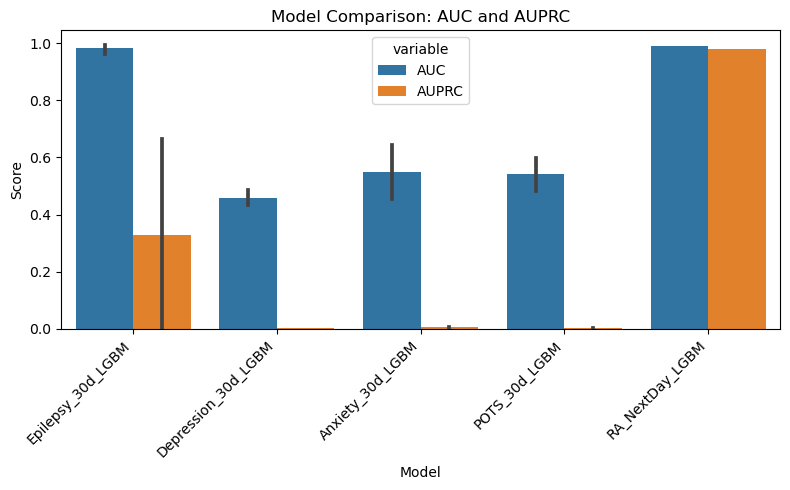

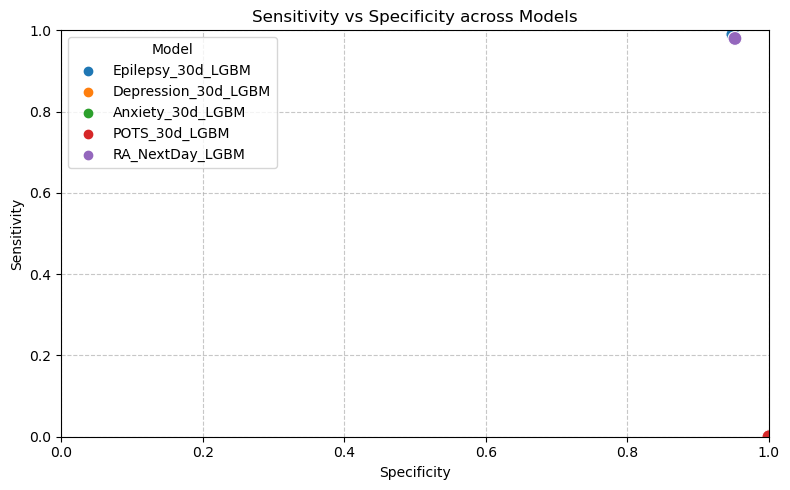

In [103]:
results_df = pd.read_csv("model_results.csv")

# --- Barplot for AUC & AUPRC --
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["AUC", "AUPRC"]),
            x="Model", y="value", hue="variable")
plt.title("Model Comparison: AUC and AUPRC")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Sensitivity vs Specificity ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=results_df, x="Specificity", y="Sensitivity", hue="Model", s=100)
plt.title("Sensitivity vs Specificity across Models")
plt.xlim(0, 1); plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cristybanuelos/Documents/GradSchool/Datathon/plots/RA_NextDay_LGBM_confusion.png'

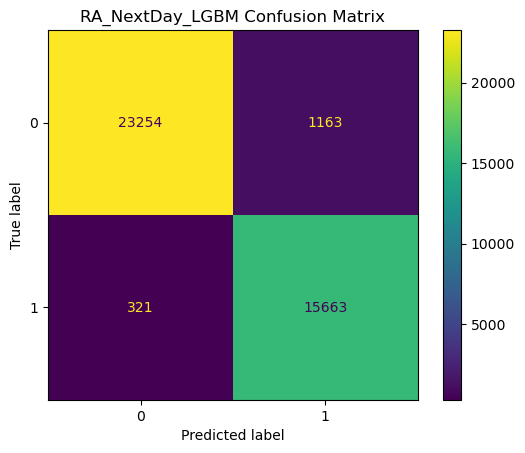

In [104]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, (p_test >= 0.5).astype(int))
plt.title(f"{model_name} Confusion Matrix")
plt.savefig(f"plots/{model_name}_confusion.png")
